In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec

from utils import *
from utilsPCA import *
from plotting import *
from efficiency import *
from isolation import *

import matplotlib as mpl

mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
mpl.rc('axes', labelsize=16, titlesize=20)
mpl.rcParams["legend.title_fontsize"]=18

#plt.style.use(hep.style.CMS)
%matplotlib inline

In [2]:
C = 29.9792458 #cm/ns

In [12]:
import os
os.listdir("new_root_files")

['histo_4Pi_NEW_1s.root',
 'histo_4Pi_NEW_2s.root',
 'histo_Pi_pt100_eta2.root',
 'histo_Pi_pt100_eta27.root',
 'histo_Pi_pt100_eta2_newPath.root',
 'histo_Pi_pt20_eta2.root',
 'histo_Pi_pt50_eta2.root',
 'histo_SinglePi_newTime.root',
 'histo_SinglePi_pt20_eta2.root',
 'histo_SinglePi_pt20_eta2_new.root',
 'histo_SinglePi_pt20to100_eta17to27.root',
 'histo_SinglePi_pt20to100_eta17to27_NEW.root',
 'histo_SinglePi_pt50_eta2.root',
 'histo_SinglePi_release.root',
 'histo_cone_new.root',
 'histo_cone_release.root',
 'histo_no_time.root',
 'histo_ph_rechits.root',
 'histo_photon_rechits.root',
 'histo_pion_rechits.root',
 'histo_rechits.root',
 'histo_rel.root',
 'histo_time_2s.root',
 'histo_time_3s.root']

In [48]:
filename = 'new_root_files/histo_pion_rechits.root'
#filename = 'new_root_files/histo_SinglePi_pt20_eta2.root'
file = uproot.open(filename)

In [49]:
file.keys()

['ticlDumper;1', 'ticlDumper/rechits;1', 'ticlDumper/simhits;1']

In [51]:
rechits = file["ticlDumper/rechits;1"]
simhits = file["ticlDumper/simhits;1"]

In [52]:
simhits.keys()

['ID', 'energy', 'position_x', 'position_y', 'position_z', 'time']

In [53]:
rec_ID = rechits["ID"].array()
rec_energy = rechits["energy"].array()
rec_position_x = rechits["position_x"].array()
rec_position_y = rechits["position_y"].array()
rec_position_z = rechits["position_z"].array()
rec_time = rechits["time"].array()
rec_time_error = rechits["time_error"].array()

sim_ID = simhits["ID"].array()
sim_energy = simhits["energy"].array()
sim_position_x = simhits["position_x"].array()
sim_position_y = simhits["position_y"].array()
sim_position_z = simhits["position_z"].array()
sim_time = simhits["time"].array()

In [59]:
res_sigma = []
res_time = []
res_energy = []
for ev in range(10): #len(rec_time)):
    rh_ids = rec_ID[ev]
    rh_times = rec_time[ev]
    rh_energy = rec_energy[ev]
    rh_timeErrs = rec_time_error[ev]
    sh_ids = sim_ID[ev]
    sh_times = sim_time[ev]
    rh_ids = rh_ids[rh_times!=-99]
    rh_times = rh_times[rh_times!=-99]
    rh_timeErrs = rh_timeErrs[rh_times!=-99]
    for i, rh_id in enumerate(rh_ids):
        try:
            sh_where = np.where(sh_ids==rh_id)
            sh_i = sh_where[0][0]
        except:
            continue
#         print(sh_where, rh_times[i], min(sh_times[sh_where[0]]))
        res_sigma.append((rh_times[i]-sh_times[sh_i])/rh_timeErrs[i])
        res_time.append(rh_times[i]-sh_times[sh_i])
        res_energy.append(rh_energy[i])

In [29]:
# returns res that contains the parameters, the chi squared and 
# the counts and bins used to plot the data
def gauss_fit(data, init_parms, bins=300):
    hist, nbins = np.histogram(data, bins=bins)
    nbins = 0.5 * (bins[1:] + bins[:-1])
    errors = [np.sqrt(oh+1) for oh in hist]
    init_parameters = init_parms
    cost_func = cost.LeastSquares(nbins, hist, errors, model)
    min_obj = Minuit(cost_func, *init_parameters)
    res = min_obj.migrad()
    chi2 = min_obj.fval/(len(nbins[:-1])-3)
    return res, chi2, hist, nbins[:-1]

#same as above but plots also the data
def gauss_fit_and_plot(data, init_parms, label="data", colors=["midnightblue","dodgerblue"], bins=300):
    res, chi2, hists, newbins = gauss_fit(data, init_parms, bins=bins)
    y = model(newbins, *res.values)
    plt.plot(newbins, y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', color=colors[0], linewidth=2)
    plt.hist(np.array(data), bins=bins, color=colors[1], alpha=0.7)
    plt.legend(fontsize=16)
    plt.grid()
    return res, chi2

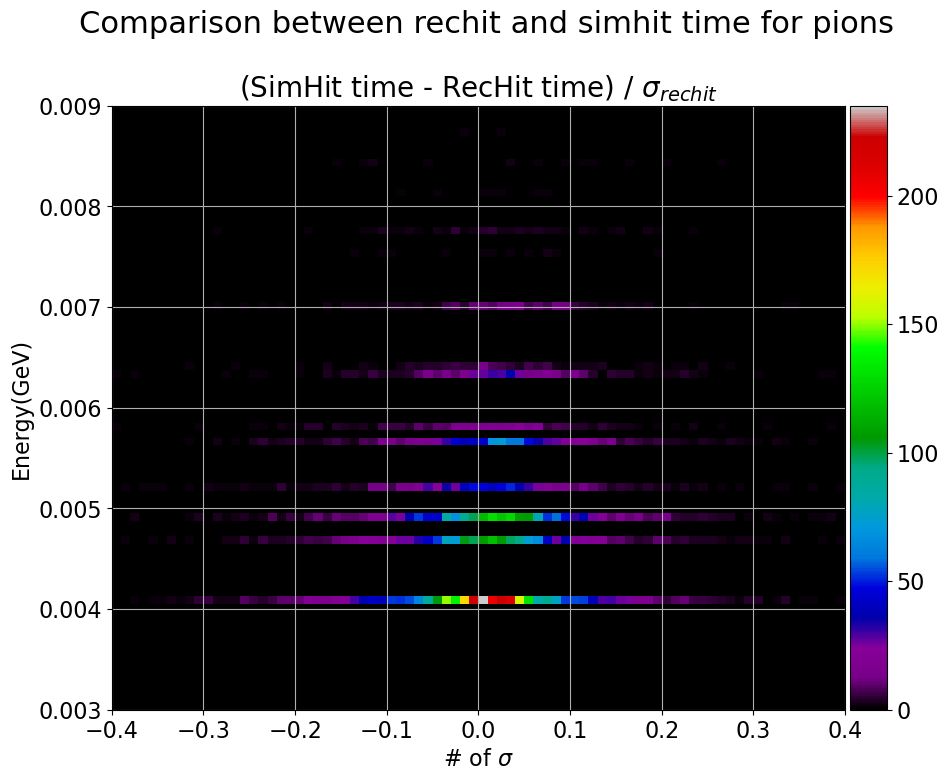

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(10,8), dpi=100)
fig.suptitle('Comparison between rechit and simhit time for pions', size=22, y=1)

#plt.figure(figsize=(10,8))
ax1.set_title("(SimHit time - RecHit time) / $\sigma_{rechit}$ ")
hist, xedges, yedges, _ = ax1.hist2d(res_sigma, res_energy, range=((-0.4,0.4),(0.003,0.009)), bins=80, cmap="nipy_spectral")
ax1.grid()
ax1.set_xlabel("# of $\sigma$")
ax1.set_ylabel("Energy(GeV)")
# plt.show()
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=min(ak.flatten(hist)), vmax=max(ak.flatten(hist)))
scamap = plt.cm.ScalarMappable(norm=norm, cmap='nipy_spectral')
fig.colorbar(scamap, cax=cax, shrink=0.9)

plt.show()

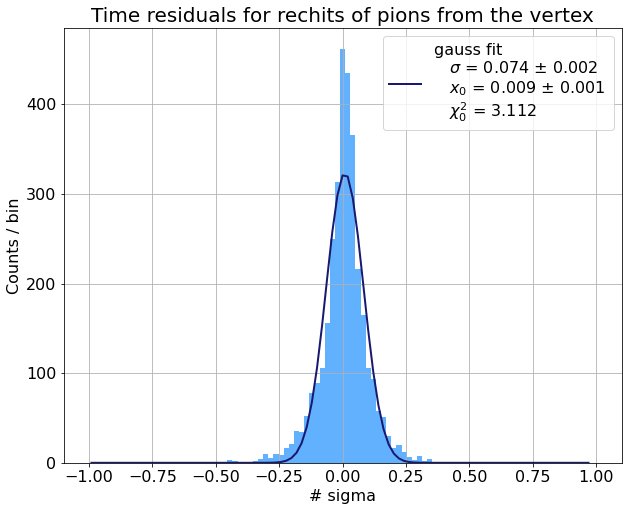

In [69]:
LIM=1
bins=60
plt.figure(figsize=(10,8))
gauss_fit_and_plot(np.array(res_sigma)[np.array(res_energy)<0.0045], init_parms=[1400,0,0.05], label="reco", bins=np.linspace(-LIM, LIM, 100))
plt.title("Time residuals for rechits of pions from the vertex")
plt.xlabel("# sigma")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

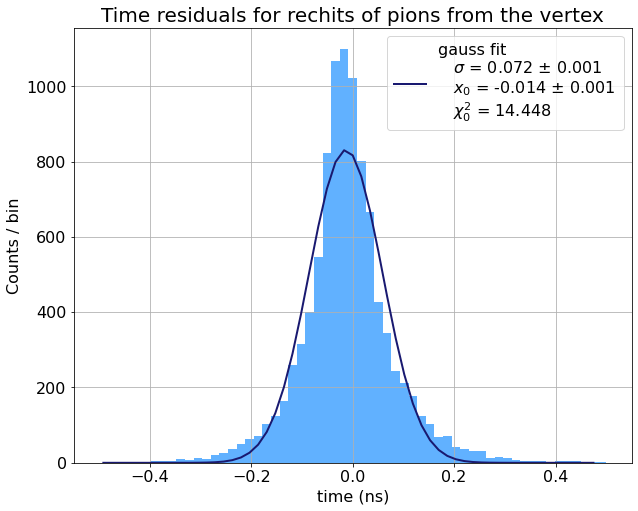

In [61]:
LIM=0.5
bins=60
plt.figure(figsize=(10,8))
gauss_fit_and_plot(res_time, init_parms=[1400,0,0.05], label="reco", bins=np.linspace(-LIM, LIM, bins))
plt.title("Time residuals for rechits of pions from the vertex")
plt.xlabel("time (ns)")
plt.ylabel("Counts / bin")
plt.legend(fontsize=16)
plt.show()

## OLD VERSION

In [12]:
from isolation import *
# import numpy as np
# import matplotlib.pyplot as plt
# from iminuit import cost, Minuit

import matplotlib as mpl

mpl.rc('legend', fontsize=15) 
mpl.rc('xtick', labelsize=22) 
mpl.rc('ytick', labelsize=22) 
mpl.rc('axes', labelsize=22, titlesize=22)

In [6]:
import os
os.listdir("/eos/user/a/aperego/cmssw/track_linking/20893.0_CloseByParticleGun+2026D88/")

['.deltaTrecVSsim.txt.swp',
 'CloseByParticle_Photon_ERZRanges_cfi_GEN_SIM.py',
 'Isolation_Mu_Isolation.txt',
 'Isolation_Mu_Track_infolist.txt',
 'cmdLog',
 'p0_365_output.txt',
 'p0_365_rechit.txt',
 'p0_365_simhit.txt',
 'p0_365_step1.txt',
 'p0_365_step2.txt',
 'p0_365_step3.txt',
 'p0_back_output.txt',
 'p0_back_rechit.txt',
 'p0_back_simhit.txt',
 'p0_back_step1.txt',
 'p0_back_step2.txt',
 'p0_back_step3.txt',
 'p0_old_output.txt',
 'p0_old_rechit.txt',
 'p0_old_simhit.txt',
 'p0_old_step1.txt',
 'p0_old_step2.txt',
 'p0_old_step3.txt',
 'p0_output.txt',
 'p0_rechit.txt',
 'p0_simhit.txt',
 'p0_step1.txt',
 'p0_step2.txt',
 'p0_step3.txt',
 'ph2_output.txt',
 'ph2_rechit.txt',
 'ph2_simhit.txt',
 'ph2_step1.txt',
 'ph2_step2.txt',
 'ph2_step3.txt',
 'ph3_output.txt',
 'ph3_rechit.txt',
 'ph3_simhit.txt',
 'ph3_step1.txt',
 'ph3_step2.txt',
 'ph3_step3.txt',
 'ph_cluster.txt',
 'ph_deltaTrecVSsim.txt',
 'ph_rechit.txt',
 'ph_sigmaRecVSsim.txt',
 'ph_simhit.txt',
 'ph_step2.txt',

## new version

In [25]:
path = "/eos/user/a/aperego/cmssw/track_linking/20893.0_CloseByParticleGun+2026D88/"
file = path + "p0_output.txt"

In [26]:
a = np.loadtxt(file, delimiter=",")
sigma = a[0]
time  = a[1]
layer = a[2]
energy= a[3]

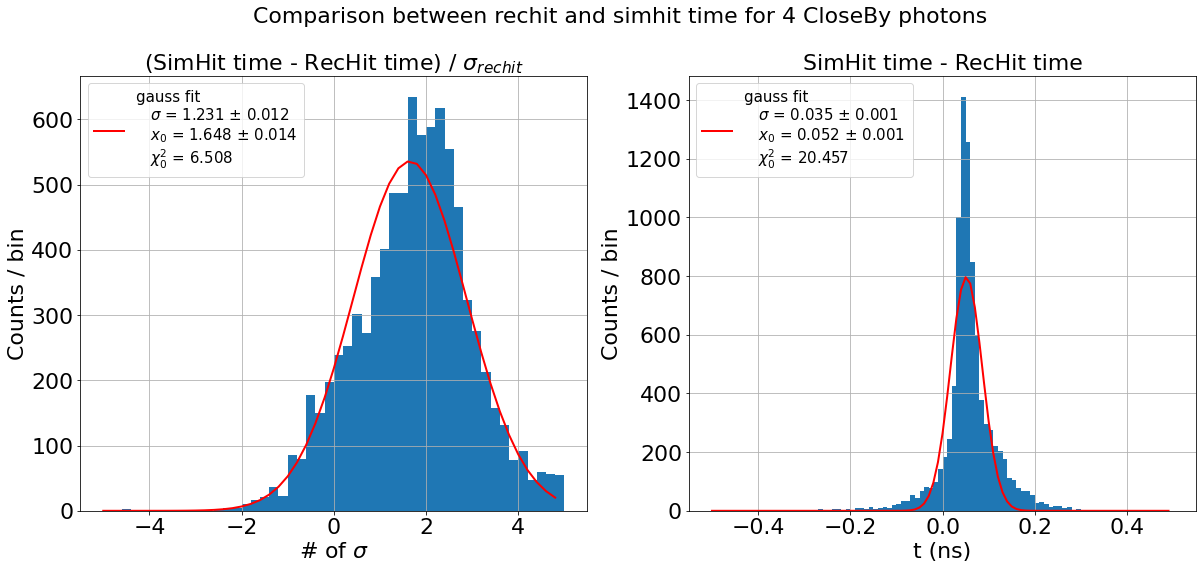

In [27]:
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
fig.suptitle('Comparison between rechit and simhit time for 4 CloseBy photons', size=22, y=1)

ran=(-5,5)
bins=50
hist, nbins = np.histogram(sigma, range=ran, bins=bins)
errors = [np.sqrt(oh+1) for oh in hist]
init_parameters = [1400,0.5,1]
cost_func = cost.LeastSquares(nbins[:-1], hist, errors, model)
min_obj = Minuit(cost_func, *init_parameters)
res = min_obj.migrad()
chi2 = min_obj.fval/(len(nbins[:-1])-3)

#plt.figure(figsize=(10,8))
ax1.set_title("(SimHit time - RecHit time) / $\sigma_{rechit}$ ")
ax1.hist(sigma, range=ran, bins=bins)
y = model(nbins[:-1], *res.values)
ax1.plot(nbins[:-1], y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', 
         color="red", linewidth=2)
ax1.grid()
ax1.set_xlabel("# of $\sigma$")
ax1.set_ylabel("Counts / bin")
ax1.legend(loc="upper left")
# plt.show()

ran=(-0.5,0.5)
bins=100
hist, nbins = np.histogram(time, range=ran, bins=bins)
errors = [np.sqrt(oh+1) for oh in hist]
init_parameters = [150,0.001,0.05]
cost_func = cost.LeastSquares(nbins[:-1], hist, errors, model)
min_obj = Minuit(cost_func, *init_parameters)
res = min_obj.migrad()
chi2 = min_obj.fval/(len(nbins[:-1])-3)

# plt.figure(figsize=(10,8))
ax2.set_title("SimHit time - RecHit time")
y = model(nbins[:-1], *res.values)
ax2.plot(nbins[:-1], y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', 
         color="red", linewidth=2)
ax2.hist(time, range=ran, bins=bins)
ax2.grid()
ax2.set_xlabel("t (ns)")
ax2.set_ylabel("Counts / bin")
ax2.legend(loc="upper left")
plt.show()

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

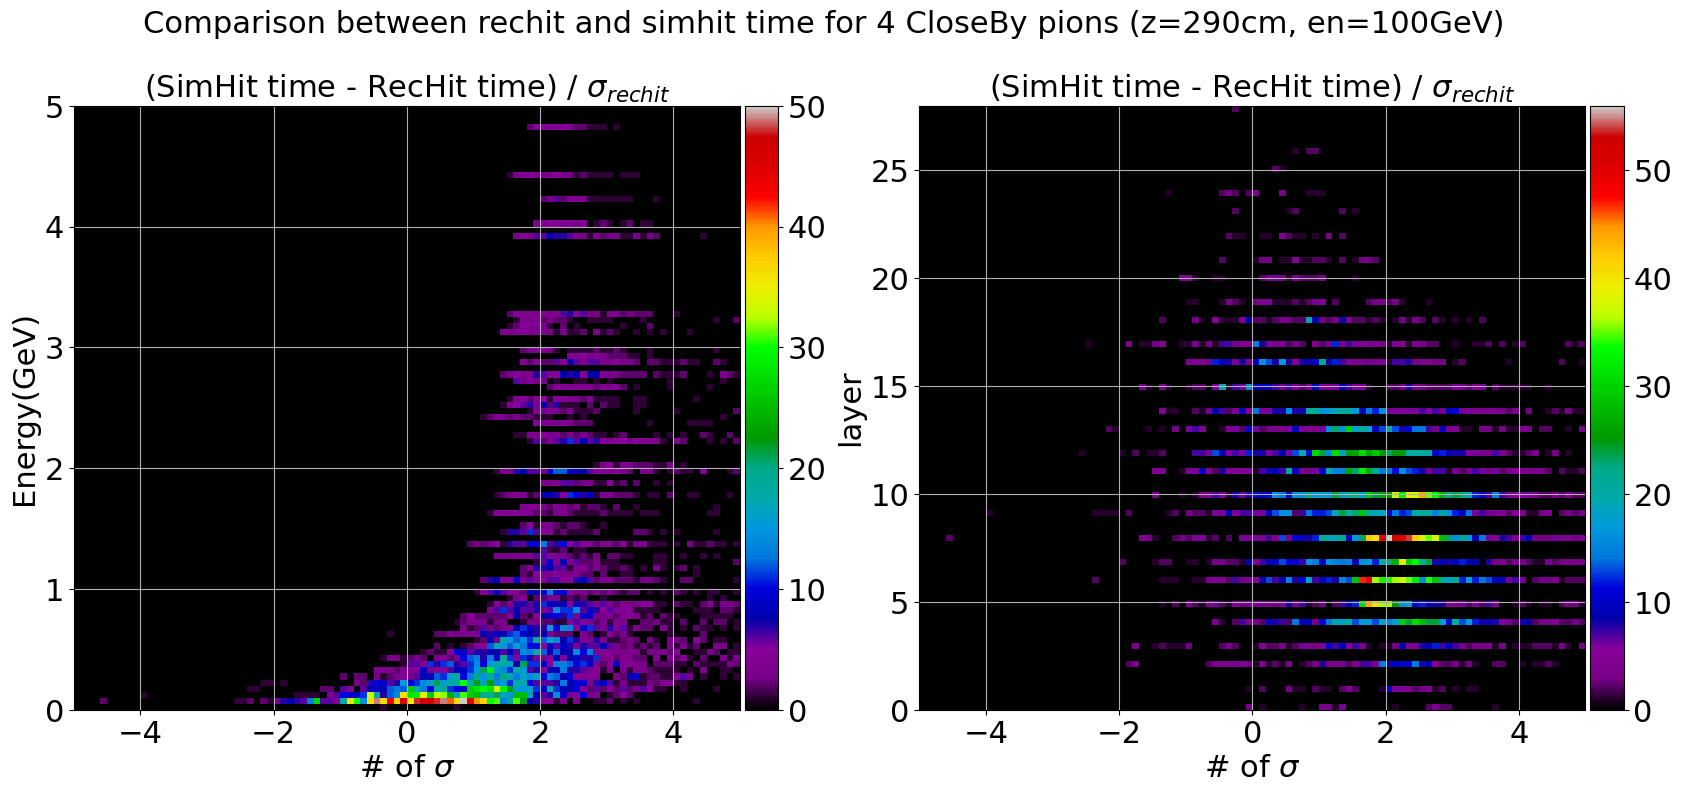

In [29]:
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,8), dpi=100)
fig.suptitle('Comparison between rechit and simhit time for 4 CloseBy pions (z=290cm, en=100GeV)', size=22, y=1)

ran=(-5,5)
bins=100

#plt.figure(figsize=(10,8))
ax1.set_title("(SimHit time - RecHit time) / $\sigma_{rechit}$ ")
hist, xedges, yedges, _ = ax1.hist2d(sigma, energy, range=((-5,5),(0,5)), bins=bins, cmap="nipy_spectral")
ax1.grid()
ax1.set_xlabel("# of $\sigma$")
ax1.set_ylabel("Energy(GeV)")
# plt.show()
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=min(ak.flatten(hist)), vmax=max(ak.flatten(hist)))
scamap = plt.cm.ScalarMappable(norm=norm, cmap='nipy_spectral')
fig.colorbar(scamap, cax=cax, shrink=0.9)

ran=(-0.5,0.5)
bins=100

# plt.figure(figsize=(10,8))
ax2.set_title("(SimHit time - RecHit time) / $\sigma_{rechit}$ ")
hist2, xedges, yedges, _ = ax2.hist2d(sigma, layer, range=((-5,5),(0,max(layer))), bins=bins, cmap="nipy_spectral")
ax2.grid()
ax2.set_xlabel("# of $\sigma$")
ax2.set_ylabel("layer")

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = mpl.colors.Normalize(vmin=min(ak.flatten(hist2)), vmax=max(ak.flatten(hist2)))
scamap = plt.cm.ScalarMappable(norm=norm, cmap='nipy_spectral')
fig.colorbar(scamap, cax=cax, shrink=0.9)

plt.show()

In [23]:
np.max(hist2)

23.0

## old version

In [6]:
path = "/eos/user/a/aperego/cmssw/track_linking/CMSSW_13_2_0_pre2/src/20893.0_CloseByParticleGun+2026D88/"
file_sigma = path + "pi_sigmaRecVSsim.txt"
file_deltaT = path + "pi_deltaTrecVSsim.txt"

data_sigma = np.loadtxt(file_sigma, delimiter=",")
data_deltaT = np.loadtxt(file_deltaT, delimiter=",")

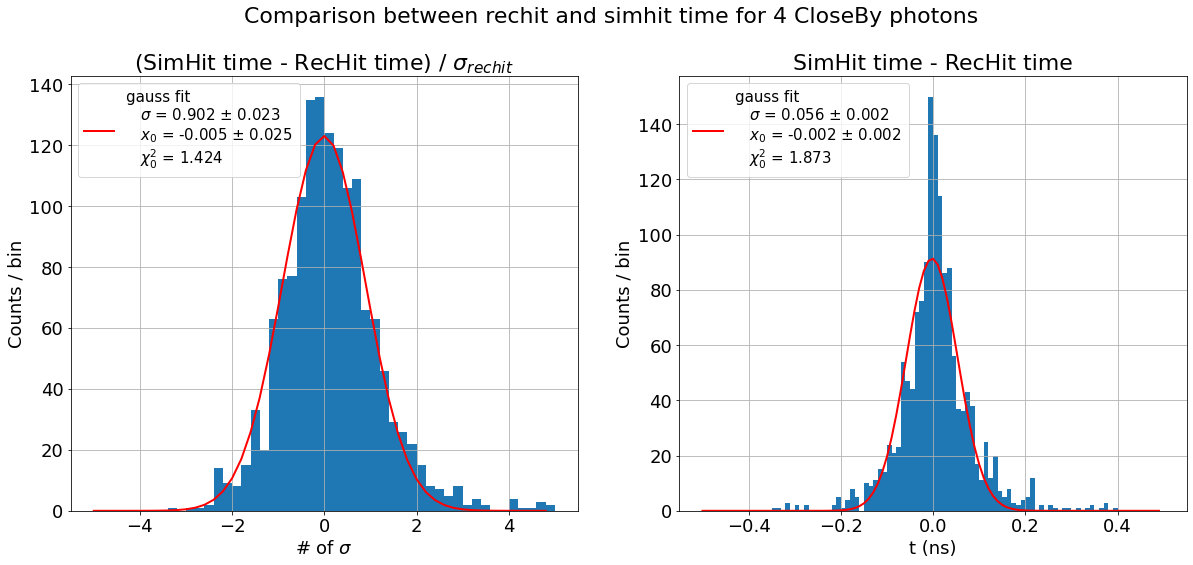

In [7]:
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
fig.suptitle('Comparison between rechit and simhit time for 4 CloseBy photons', size=22, y=1)

ran=(-5,5)
bins=50
hist, nbins = np.histogram(data_sigma, range=ran, bins=bins)
errors = [np.sqrt(oh+1) for oh in hist]
init_parameters = [1400,0.5,1]
cost_func = cost.LeastSquares(nbins[:-1], hist, errors, model)
min_obj = Minuit(cost_func, *init_parameters)
res = min_obj.migrad()
chi2 = min_obj.fval/(len(nbins[:-1])-3)

#plt.figure(figsize=(10,8))
ax1.set_title("(SimHit time - RecHit time) / $\sigma_{rechit}$ ")
ax1.hist(data_sigma, range=ran, bins=bins)
y = model(nbins[:-1], *res.values)
ax1.plot(nbins[:-1], y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', 
         color="red", linewidth=2)
ax1.grid()
ax1.set_xlabel("# of $\sigma$")
ax1.set_ylabel("Counts / bin")
ax1.legend(loc="upper left")
# plt.show()

ran=(-0.5,0.5)
bins=100
hist, nbins = np.histogram(data_deltaT, range=ran, bins=bins)
errors = [np.sqrt(oh+1) for oh in hist]
init_parameters = [150,0.001,0.05]
cost_func = cost.LeastSquares(nbins[:-1], hist, errors, model)
min_obj = Minuit(cost_func, *init_parameters)
res = min_obj.migrad()
chi2 = min_obj.fval/(len(nbins[:-1])-3)

# plt.figure(figsize=(10,8))
ax2.set_title("SimHit time - RecHit time")
y = model(nbins[:-1], *res.values)
ax2.plot(nbins[:-1], y, label=f'gauss fit\n   $\sigma$ = {res.values[2]:.3f} $\pm$ {res.errors[2]:.3f}\n   $x_0$ = {res.values[1]:.3f} $\pm$ {res.errors[1]:.3f} \n   $\chi^2_0$ = {chi2:.3f}', 
         color="red", linewidth=2)
ax2.hist(data_deltaT, range=ran, bins=bins)
ax2.grid()
ax2.set_xlabel("t (ns)")
ax2.set_ylabel("Counts / bin")
ax2.legend(loc="upper left")
plt.show()